### 1. Import necessary packages and set working directory

In [1]:
import os
from glob import glob

import numpy as np
from shapely.geometry import box
from shapely.geometry import mapping
from shapely.wkt import loads
import matplotlib.pyplot as plt
import seaborn as sns
import rioxarray as rxr
from rioxarray import merge
from rasterio.plot import plotting_extent
from rasterio.mask import mask
from rasterio.plot import show
import earthpy as et
import earthpy.plot as ep
import geopandas as gpd
from fiona.crs import from_epsg


# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")


In [2]:
os.chdir(os.path.join(et.io.HOME, 
                     'Dropbox',
                     'fraser_ef_kremer', 
                     'LIDAR'))
os.getcwd()

'/Users/laurenkremer/Dropbox/fraser_ef_kremer/LIDAR'

1. open all of the dsm files
2. mosaic them in to one large file and clip out watershed geometries
    1. East St. Louis to Fraser
    2. Fool
    3. East St. Louis to outlet
    4. Deadhorse
    5. Lexen

### 2. Load data 
#### a. we'll start with bare earth digital elevation models

In [3]:
# Make a list of files

In [4]:
# Indicate path to site directories
dem_path = os.path.join(os.getcwd(), 
                              "rasters", 
                              "bare_earth_digital_elevation_models")
# Get a list of both site directories 
dem_folders = sorted(glob(dem_path + "/*[!info]/")) # opens a list of folders excluding the metadata folder

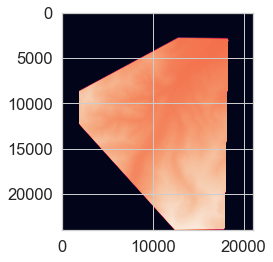

<AxesSubplot:>

In [5]:
elements = []

for val in dem_folders:
    elements.append(rxr.open_rasterio(val,masked=True).squeeze())

merged = merge.merge_arrays(elements, nodata=0.0)

image = merged.values
show(image)

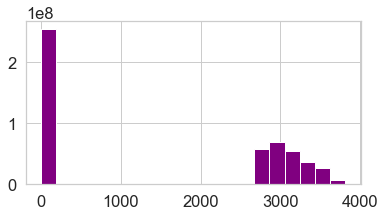

In [6]:
# Explore the data
ep.hist(merged.values,
        figsize=(6, 3))
plt.show()

In [7]:
# Set all values that are 0 to nan (no data)
merged_no_zeros = merged.where(merged != 0, np.nan)

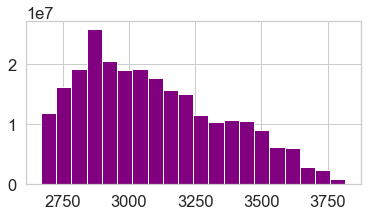

In [8]:
# Explore the data
ep.hist(merged_no_zeros.values,
        figsize=(6, 3))
plt.show()

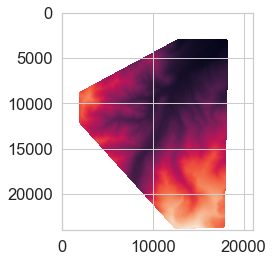

<AxesSubplot:>

In [9]:
image = merged_no_zeros.values
show(image)

In [10]:
# #plt.show()
merged_no_zeros.min() 

<xarray.DataArray ()>
array(2668.7532, dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

In [11]:
# Sweet, now lets clip this a few times:

In [12]:
# Open crop boundaries
def open_boundary(site_path):
    """open .shp as geopandas df
    Parameters
    -----------
    vector_path : a path to the directory containing desire shapefile
        
    Returns
    -----------
    gpd : a geopandas geodataframe 
    """
    # Open crop boundary
    site_name = site_path.split('/')[7]
    crop_bound = gpd.read_file(site_path)
    crop_bound['Site'] = site_name 
    return crop_bound

In [13]:
# First let's import the FEF shapefiles:

In [14]:
# Indicate path to site directories
shp_path = os.path.join(os.getcwd(), 
                              "study_shapefiles")


# generate a list if 
site_list = sorted(glob(shp_path + "/*/*.shp"))


# Open shapefiles using open_boundary function
bounds = []
for i in site_list:
    boundy = open_boundary(i)
    bounds.append(boundy)

In [15]:
# check the projections

print('boundary', bounds[1].crs)
print("dem", merged_no_zeros.rio.crs)

boundary epsg:4326
dem PROJCS["unnamed",GEOGCS["Unknown datum based upon the GRS 1980 ellipsoid (deprecated)",DATUM["Not_specified_based_on_GRS_1980_ellipsoid",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6019"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4019"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["METERS",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [16]:
# Reproject boundary data to match dsm data:
merged_no_zeros = merged_no_zeros.rio.reproject("EPSG:32613")

rprj_bounds = []

for i in bounds:
    reproj_bounds =i.to_crs(merged_no_zeros.rio.crs)
    rprj_bounds.append(reproj_bounds)


In [17]:
# check the projections

print('boundary', rprj_bounds[1].crs)
print("dem", merged_no_zeros.rio.crs)

boundary PROJCS["WGS 84 / UTM zone 13N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32613"]]
dem EPSG:32613


In [18]:
# Identify plot_extent variable for plotting
dem_extent = list(merged_no_zeros.rio.bounds())
dem_extent[1], dem_extent[2] = dem_extent[2], dem_extent[1]
dem_extent = tuple(list(dem_extent))

In [19]:
dem_extent

(418500.0000005491, 429000.00000059226, 4410000.000113753, 4422000.000113802)

<AxesSubplot:>

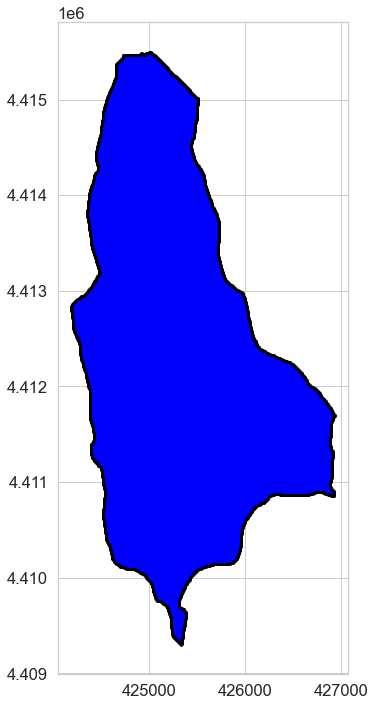

In [20]:

# Define plot space
fig, (ax) = plt.subplots(figsize=(12, 12))

# Add fire boundary
rprj_bounds[1].plot(ax=ax,
                 edgecolor="black",
                 linewidth=3,
                 color="blue")

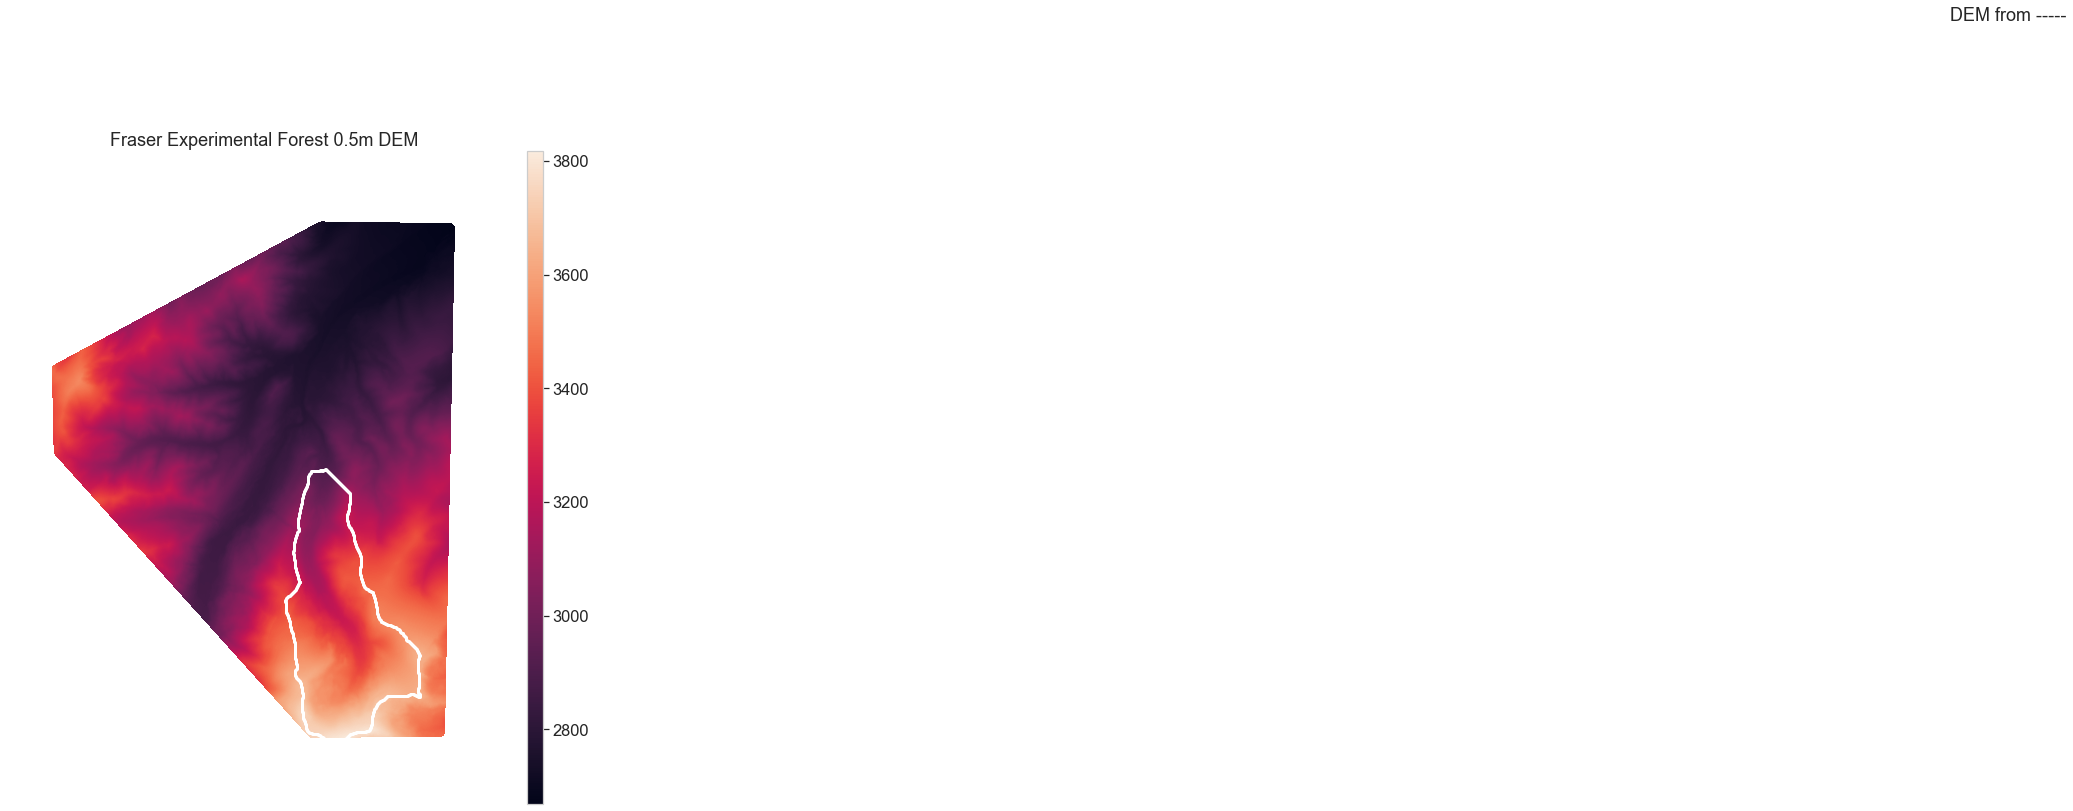

In [21]:
# Plot DEM with a shapefile superimposed

# Define plot space
fig, (ax) = plt.subplots(figsize=(12, 12))

im = ax.imshow(merged_no_zeros.squeeze(),
              extent = dem_extent)
ep.colorbar(im)

ax.set(title="Fraser Experimental Forest 0.5m DEM")


# Add fire boundary
rprj_bounds[1].plot(ax=ax,
                 edgecolor="white",
                 linewidth=3,
                 color="none")

# Citation text
ax.text(459400.0, 4424670.0, "DEM from -----" ,          
         horizontalalignment='center',
         bbox=dict(facecolor='white', alpha=0.5))

ax.set_axis_off()
plt.show()


In [22]:
#merged_no_zeros.T.plot.surface()

In [23]:
# Now we have a list of geopandas frames, we can crop

cropped_dems = []

for i in rprj_bounds:
    clipd = merged_no_zeros.rio.clip(i.geometry)
    clipd_no_zeros = clipd.where(clipd != 0, np.nan)
    cropped_dems.append(clipd_no_zeros)

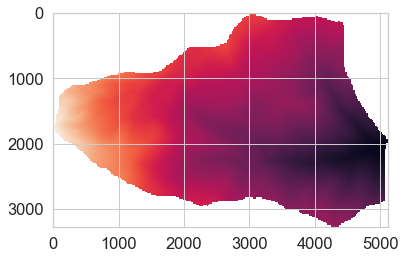

<AxesSubplot:>

In [24]:
image = cropped_dems[0].values
show(image)

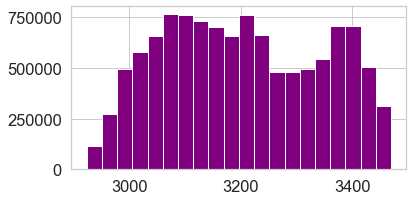

In [25]:
# Explore the data
ep.hist(cropped_dems[3].values,
        figsize=(6, 3))
plt.show()

In [26]:
# EXPORT DEMS for use in other applications

cropped_dems[0].rio.to_raster("deadhorse_0.5m_DEM.tif")
cropped_dems[1].rio.to_raster("est_stlouis_0.5m_DEM.tif")
cropped_dems[2].rio.to_raster("fef_0.5m_DEM.tif")
cropped_dems[3].rio.to_raster("fool_0.5m_DEM.tif")
cropped_dems[4].rio.to_raster("lexen_0.5m_DEM.tif")

### Now that we have cropped dsm arrays, lets repeat for dtm

In [27]:
# Indicate path to site directories
dsm_path = os.path.join(os.getcwd(), 
                              "rasters", 
                              "highest_hit_digital_surface_models")
# Get a list of both site directories 
dsm_folders = sorted(glob(dsm_path + "/*[!info]/")) # opens a list of folders excluding the metadata folder

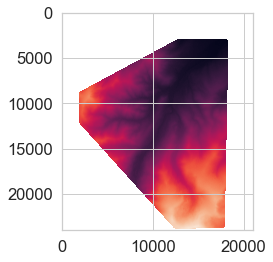

<AxesSubplot:>

In [28]:
elements = []

for val in dsm_folders:
    elements.append(rxr.open_rasterio(val,masked=True).squeeze())

merged = merge.merge_arrays(elements, nodata=0.0)

# Set all values that are 0 to nan (no data)
merged_no_zeros = merged.where(merged != 0, np.nan)

image = merged_no_zeros.values
show(image)

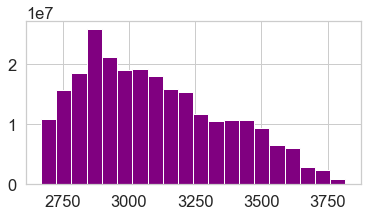

In [29]:
# Explore the data
ep.hist(merged_no_zeros.values,
        figsize=(6, 3))
plt.show()

In [30]:
# Reproject boundary data to match dsm data:
merged_no_zeros = merged_no_zeros.rio.reproject("EPSG:32613")

rprj_bounds = []

for i in bounds:
    reproj_bounds =i.to_crs(merged_no_zeros.rio.crs)
    rprj_bounds.append(reproj_bounds)

In [31]:
print('boundary', rprj_bounds[1].crs)
print("dsm", merged_no_zeros.rio.crs)

boundary PROJCS["WGS 84 / UTM zone 13N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32613"]]
dsm EPSG:32613


In [32]:
# Identify plot_extent variable for plotting
dsm_extent = list(merged_no_zeros.rio.bounds())
dsm_extent[1], dsm_extent[2] = dsm_extent[2], dsm_extent[1]
dsm_extent = tuple(list(dsm_extent))

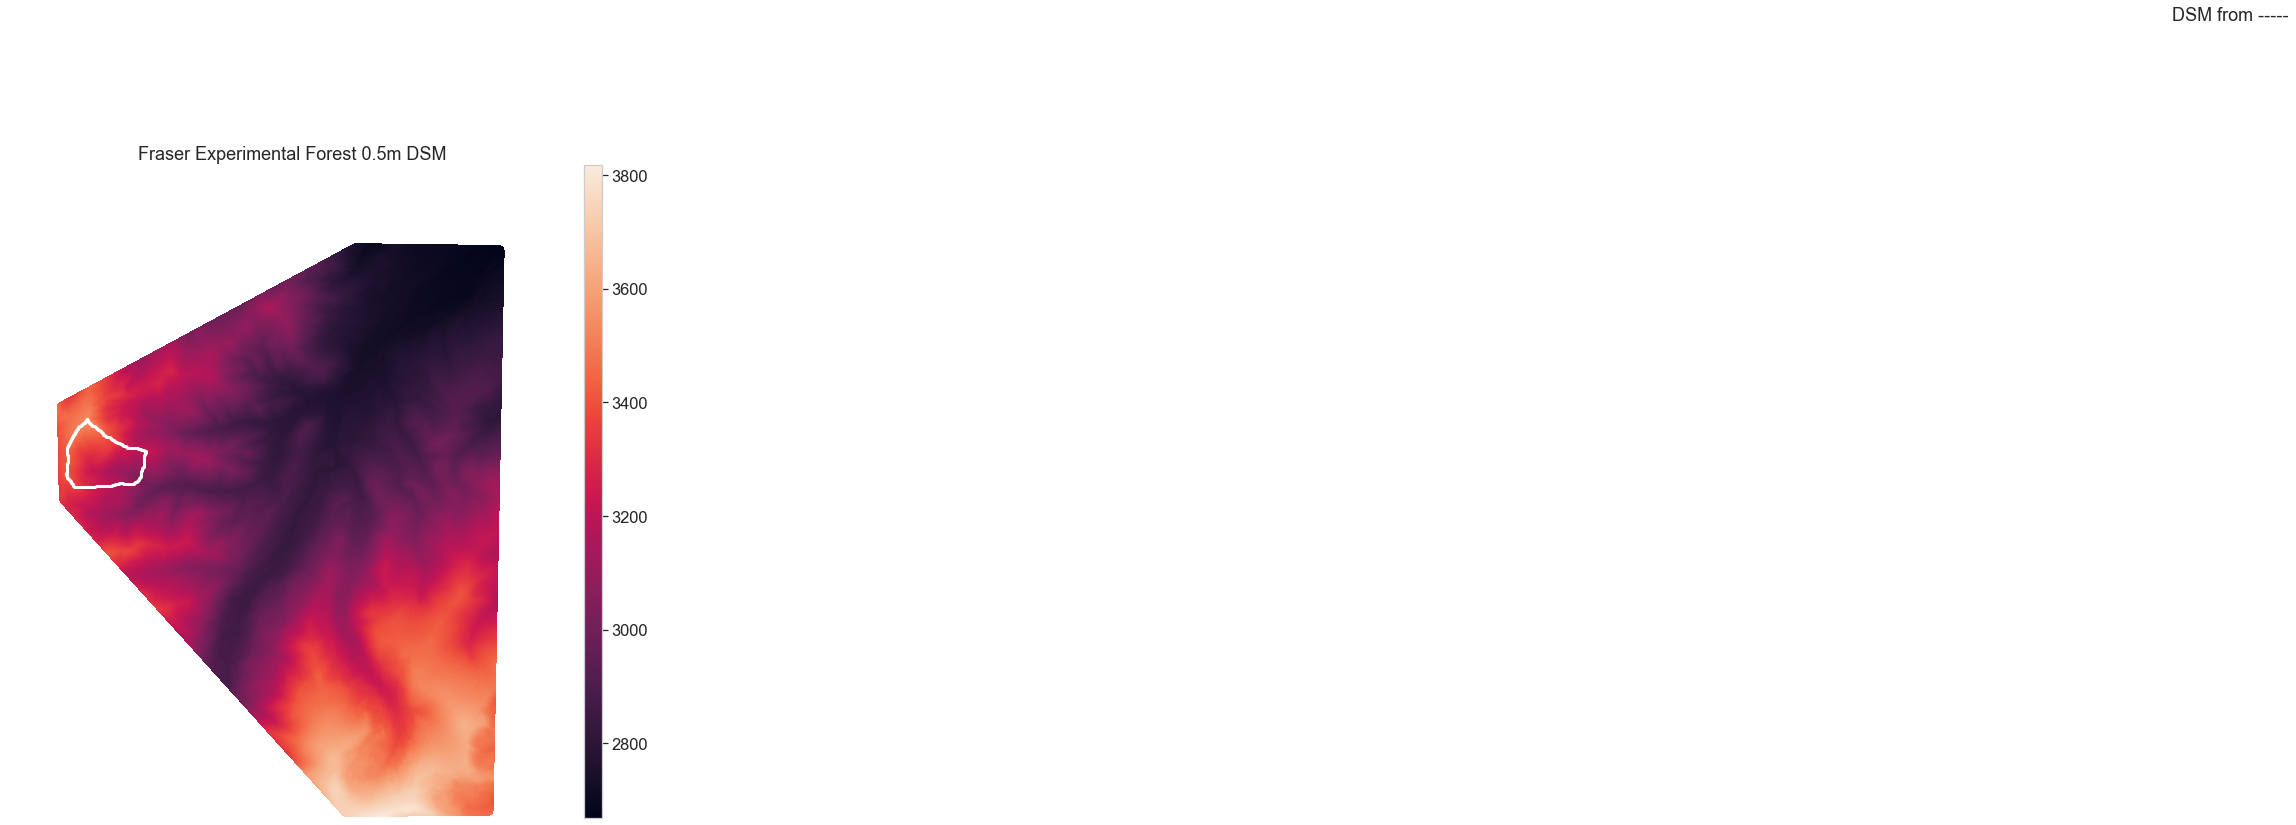

In [33]:
# Plot DSM with a shapefile superimposed

# Define plot space
fig, (ax) = plt.subplots(figsize=(12, 12))

im = ax.imshow(merged_no_zeros.squeeze(),
              extent = dsm_extent)
ep.colorbar(im)

ax.set(title="Fraser Experimental Forest 0.5m DSM")


# Add fire boundary
rprj_bounds[4].plot(ax=ax,
                 edgecolor="white",
                 linewidth=3,
                 color="none")

# Citation text
ax.text(459400.0, 4424670.0, "DSM from -----" ,          
         horizontalalignment='center',
         bbox=dict(facecolor='white', alpha=0.5))

ax.set_axis_off()
plt.show()



In [34]:
# Lets crop to unique DSMs
cropped_dsms = []

for i in rprj_bounds:
    clipd = merged_no_zeros.rio.clip(i.geometry)
    clipd_no_zeros = clipd.where(clipd != 0, np.nan)
    cropped_dsms.append(clipd_no_zeros)

### c. check that the two datasets are comparable

In [35]:
# Are the bounds the same?
print("Is the spatial extent the same?",
      cropped_dsms[1].rio.bounds() == cropped_dems[1].rio.bounds())

# Is the resolution the same ??
print("Is the resolution the same?",
      cropped_dsms[1].rio.resolution() == cropped_dsms[1].rio.resolution())

Is the spatial extent the same? True
Is the resolution the same? True


In [36]:
### 3. Calculate the canopy height model
# Calculate canopy height model
deadhorse_chm_xr = cropped_dsms[0] -cropped_dems[0]
est_stlouis_chm_xr = cropped_dsms[1] -cropped_dems[1]
fef_chm_xr = cropped_dsms[2] -cropped_dems[2]
fool_chm_xr = cropped_dsms[3] -cropped_dems[3]
lexen_chm_xr = cropped_dsms[4] -cropped_dems[4]

In [37]:
deadhorse_chm_xr.rio.to_raster("deadhorse_0.5m_CHM.tif")
est_stlouis_chm_xr.rio.to_raster("est_stlouis_0.5m_CHM.tif")
fef_chm_xr.rio.to_raster("fef_0.5m_CHM.tif")
fool_chm_xr.rio.to_raster("fool_0.5m_CHM.tif")
lexen_chm_xr.rio.to_raster("lexen_0.5m_CHM.tif")

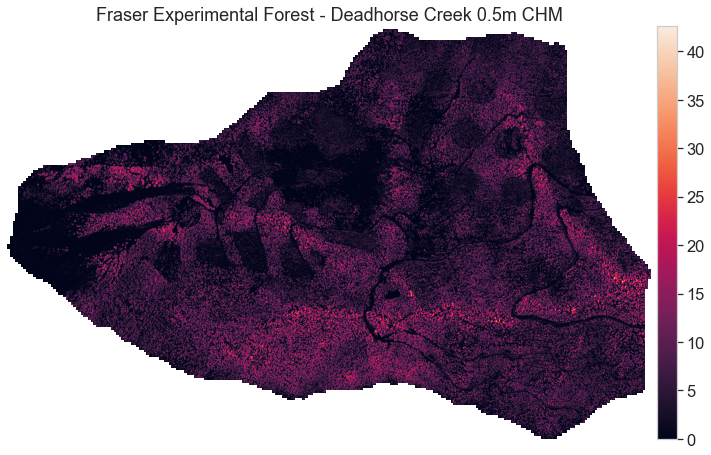

In [38]:
# Identify plot_extent variable for plotting
dh_extent = list(deadhorse_chm_xr.rio.bounds())
dh_extent[1], dh_extent[2] = dh_extent[2], dh_extent[1]
dh_extent = tuple(list(dh_extent))

# Define plot space
fig, (ax) = plt.subplots(figsize=(12, 12))

im = ax.imshow(deadhorse_chm_xr.squeeze(),
              extent = dh_extent)
ep.colorbar(im)

ax.set(title="Fraser Experimental Forest - Deadhorse Creek 0.5m CHM")
ax.set_axis_off()

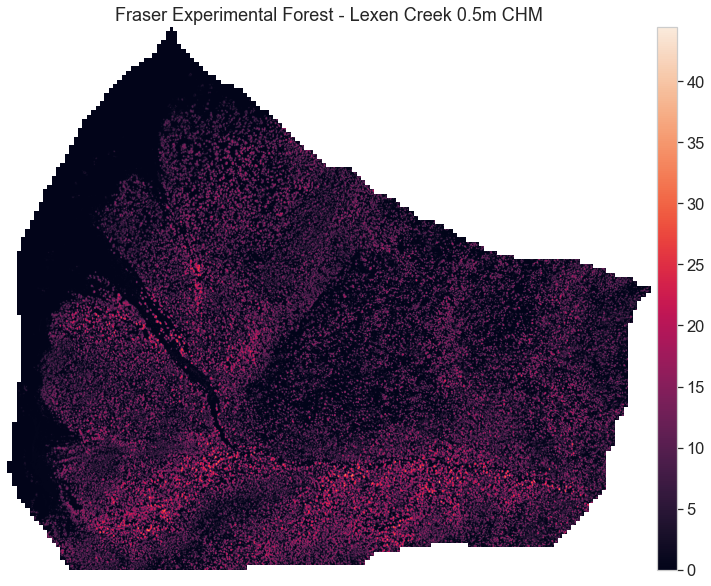

In [39]:
# Identify plot_extent variable for plotting
lx_extent = list(lexen_chm_xr.rio.bounds())
lx_extent[1], lx_extent[2] = lx_extent[2], lx_extent[1]
lx_extent = tuple(list(lx_extent))

# Define plot space
fig, (ax) = plt.subplots(figsize=(12, 12))

im = ax.imshow(lexen_chm_xr.squeeze(),
              extent = lx_extent)
ep.colorbar(im)

ax.set(title="Fraser Experimental Forest - Lexen Creek 0.5m CHM")
ax.set_axis_off()

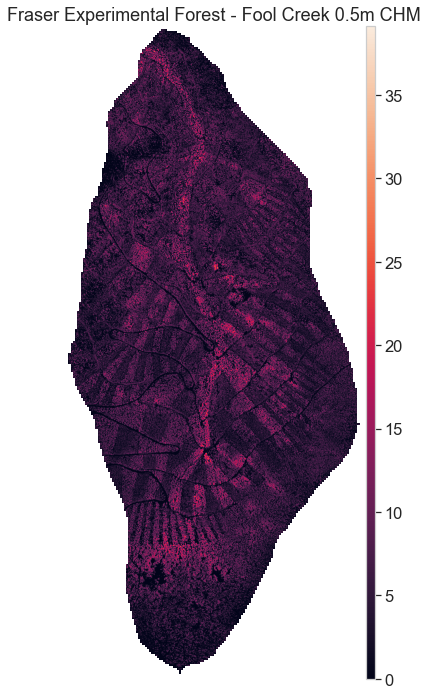

In [40]:
# Identify plot_extent variable for plotting
fool_extent = list(fool_chm_xr.rio.bounds())
fool_extent[1], fool_extent[2] = fool_extent[2], fool_extent[1]
fool_extent = tuple(list(fool_extent))

# Define plot space
fig, (ax) = plt.subplots(figsize=(12, 12))

im = ax.imshow(fool_chm_xr.squeeze(),
              extent = fool_extent)
ep.colorbar(im)

ax.set(title="Fraser Experimental Forest - Fool Creek 0.5m CHM")
ax.set_axis_off()

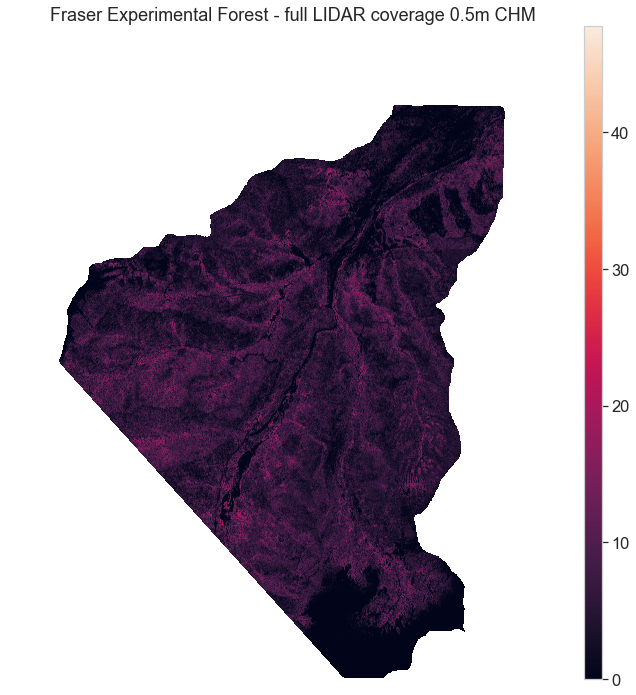

In [41]:
# Identify plot_extent variable for plotting
fef_extent = list(fef_chm_xr.rio.bounds())
fef_extent[1], fef_extent[2] = fef_extent[2], fef_extent[1]
fef_extent = tuple(list(fef_extent))

# Define plot space
fig, (ax) = plt.subplots(figsize=(12, 12))

im = ax.imshow(fef_chm_xr.squeeze(),
              extent = fef_extent)
ep.colorbar(im)

ax.set(title="Fraser Experimental Forest - full LIDAR coverage 0.5m CHM")
ax.set_axis_off()